In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.linear_model import LogisticRegression as LR
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
import pickle
from skimage import io
from extract_features import extract_features

In [3]:
# Where is the raw provided data
file_data_good = r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Good.csv"
file_data_mixed = r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Mixed.csv"
file_data_bad = r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Bad.csv"

image_folders = [
    r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TrainingGood",
    r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TrainingMixed",
    r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TrainingBad"
]

# Where we will store the features
file_features_good = r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Features\Good_features.csv"
file_features_mixed = r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Features\Mixed_features.csv"
file_features_bad = r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Features\Bad_features.csv"

def process_images(file_data, image_folder, file_features):
    # Read meta-data into a Pandas dataframe
    df = pd.read_csv(file_data)

    # Extract features from the image folder
    features_df = extract_features_folder(image_folder)

    # Merge the features DataFrame with the diagnostic column from the original DataFrame
    df_merged = pd.merge(df[['img_id', 'diagnostic']], features_df, on='img_id', how='inner')
    
    # Create the directory if it doesn't exist
    directory = os.path.dirname(file_features)
    if not os.path.exists(directory):
        os.makedirs(directory)
    
    df_merged.to_csv(file_features, index=False)
    print(f"Processed Images in {image_folder}: Done")

def extract_features_folder(path_image):
    features = []

    for filename in os.listdir(path_image):
        if filename.endswith(('.jpg', '.png')):
            img_id = os.path.splitext(filename)[0]  # Remove file extension
            image_path = os.path.join(path_image, filename)
            image = io.imread(image_path)

            image_features = extract_features(image)
            image_features["img_id"] = img_id
            features.append(image_features)

    features_df = pd.DataFrame(features)
    return features_df

# Process images for each set
process_images(file_data_good, image_folders[0], file_features_good)
process_images(file_data_mixed, image_folders[1], file_features_mixed)
process_images(file_data_bad, image_folders[2], file_features_bad)

Processed Images in C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TrainingGood: Done
Processed Images in C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TrainingMixed: Done
Processed Images in C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TrainingBad: Done


In [16]:
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.model_selection import GroupKFold
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.linear_model import LogisticRegression as LR
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

def get_metrics(classifiers, x, y, patient_id):
    num_folds = 5
    num_classifiers = len(classifiers)
    acc_val = np.empty([num_folds, num_classifiers])
    f1_val = np.empty([num_folds, num_classifiers])
    precision = np.empty([num_folds, num_classifiers])
    recall = np.empty([num_folds, num_classifiers])
    roc_auc = np.empty([num_folds, num_classifiers])
    
    group_kfold = GroupKFold(n_splits=num_folds)
    for i, (train_index, val_index) in enumerate(group_kfold.split(x, y, patient_id)):
        x_train, x_val = x[train_index, :], x[val_index, :]
        y_train, y_val = y[train_index], y[val_index]
        for j, clf in enumerate(classifiers):
            clf.fit(x_train, y_train)
            predictions = clf.predict(x_val)
            acc_val[i, j] = accuracy_score(y_val, predictions)
            f1_val[i, j] = f1_score(y_val, predictions)
            precision[i, j] = precision_score(y_val, predictions, zero_division=0)
            recall[i, j] = recall_score(y_val, predictions)
            roc_auc[i, j] = roc_auc_score(y_val, predictions)

    return acc_val, f1_val, precision, recall, roc_auc


# Define absolute paths for the features
absolute_paths = [r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Features\Good_features.csv", r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Features\mixed_features.csv", r"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Features\bad_features.csv"]
datasets = ['Good', 'Mixed', 'Bad']

# Define classifiers
classifiers = [KNN(5), LR(max_iter=5000), DTC()]
classifier_names = ["KNN", "LR", "DTC"]

# Initialize an empty dataframe to store all the results
all_results = pd.DataFrame()

# Loop over datasets
for absolute_path, dataset in zip(absolute_paths, datasets):
    print(f"Processing {dataset} dataset...")
    # Read data
    df_merged = pd.read_csv(absolute_path)
    x = np.array(df_merged.drop(['img_id', 'diagnostic'], axis=1))
    y = df_merged['diagnostic']
    patient_id = df_merged['img_id']

    # Define different feature selection methods
    pca = PCA(n_components=5)
    x_pca = pca.fit_transform(x)
    var_thresh = VarianceThreshold(threshold=0.1)
    x_var = var_thresh.fit_transform(x)

    feature_selections = {
        "None": x,
        "Variance Threshold": x_var,
        "PCA": x_pca
    }

    feature_selection_models = {
        "None": None,
        "Variance Threshold": var_thresh,
        "PCA": pca
    }

    # Loop over feature selections
    for feature_selection_name, x_selected in feature_selections.items():
        # Save the feature selection model if it's PCA or Variance Threshold
        feature_selection_model = feature_selection_models[feature_selection_name]
        if feature_selection_model is not None:
            # Create a directory if it does not exist
            model_dir = fr"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/{dataset}/{feature_selection_name}"
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)

            # Save the feature selection model
            model_path = f"{model_dir}/{feature_selection_name.lower()}_model.pkl"
            pickle.dump(feature_selection_model, open(model_path, 'wb'))
            print(f"Saved {feature_selection_name} model for {dataset} dataset at {model_path}.")

        # Get performance metrics
        acc_val, f1_val, precision, recall, roc_auc = get_metrics(classifiers, x_selected, y, patient_id)

        # Loop over classifiers
        for clf, clf_name in zip(classifiers, classifier_names):
            # Prepare the results for this classifier and feature selection method
            results = {
                "Dataset": dataset,
                "Feature Selection": feature_selection_name,
                "Classifier": clf_name,
                "F1 Score": np.mean(f1_val),
                "Accuracy": np.mean(acc_val),
                "Precision": np.mean(precision),
                "Recall": np.mean(recall),
                "ROC AUC": np.mean(roc_auc)
            }
            # Append the results to the dataframe
            all_results = all_results.append(results, ignore_index=True)

            # Fit the classifier on the selected features
            classifier = clf.fit(x_selected, y)

            # Create a directory if it does not exist
            model_dir = fr"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/{dataset}/{feature_selection_name}"
            if not os.path.exists(model_dir):
                os.makedirs(model_dir)

            # Save the classifier
            model_path = f"{model_dir}/{clf_name}_model.pkl"
            pickle.dump(classifier, open(model_path, 'wb'))
            print(f"Saved {clf_name} model for {dataset} dataset with {feature_selection_name} feature selection at {model_path}.")

# Print the results
print(all_results)


Processing Good dataset...
Saved KNN model for Good dataset with None feature selection at C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/Good/None/KNN_model.pkl.
Saved LR model for Good dataset with None feature selection at C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/Good/None/LR_model.pkl.
Saved DTC model for Good dataset with None feature selection at C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/Good/None/DTC_model.pkl.
Saved Variance Threshold model for Good dataset at C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/Good/Variance Threshold/variance threshold_model.pkl.
Saved KNN model for Good dataset with Variance Threshold feature selection at C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/Good/Variance Threshold/KNN_model.pkl.
Saved LR model for Good dataset with Variance Threshold feature selection at C:\U

In [17]:
all_results 

,Dataset,Feature Selection,Classifier,F1 Score,Accuracy,Precision,Recall,ROC AUC
0,Good,None,KNN,0.816431,0.742857,0.797626,0.854230,0.696271
1,Good,None,LR,0.816431,0.742857,0.797626,0.854230,0.696271
2,Good,None,DTC,0.816431,0.742857,0.797626,0.854230,0.696271
3,Good,Variance Threshold,KNN,0.814585,0.739683,0.795126,0.854230,0.693240
4,Good,Variance Threshold,LR,0.814585,0.739683,0.795126,0.854230,0.693240
5,Good,Variance Threshold,DTC,0.814585,0.739683,0.795126,0.854230,0.693240
6,Good,PCA,KNN,0.835081,0.771429,0.822869,0.865994,0.732802
7,Good,PCA,LR,0.835081,0.771429,0.822869,0.865994,0.732802
8,Good,PCA,DTC,0.835081,0.771429,0.822869,0.865994,0.732802
9,Mixed,None,KNN,0.734594,0.656313,0.712543,0.778168,0.612053


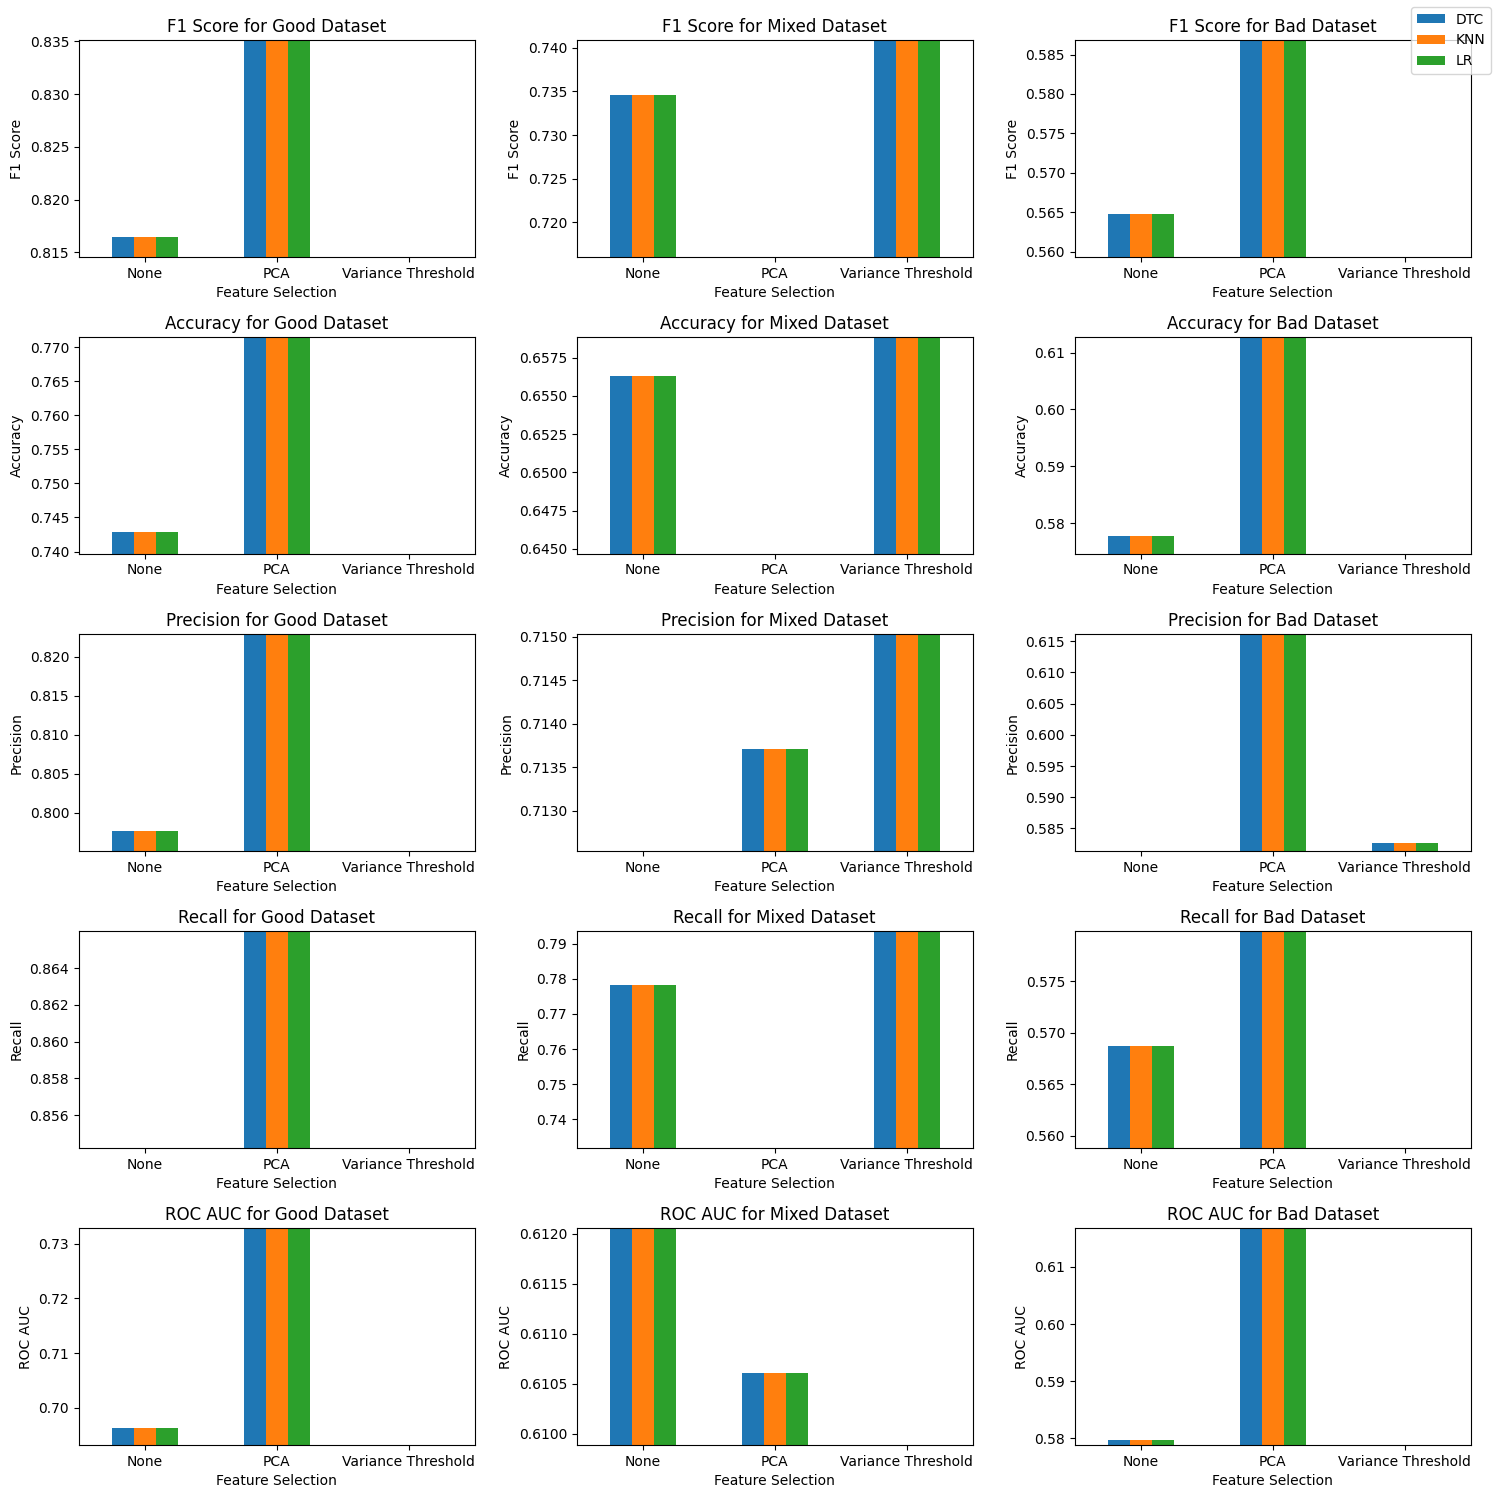

Best configuration for F1 Score:
Dataset                  Good
Feature Selection         PCA
Classifier                KNN
F1 Score             0.835081
Accuracy             0.771429
Precision            0.822869
Recall               0.865994
ROC AUC              0.732802
Name: 6, dtype: object
Best configuration for Accuracy:
Dataset                  Good
Feature Selection         PCA
Classifier                KNN
F1 Score             0.835081
Accuracy             0.771429
Precision            0.822869
Recall               0.865994
ROC AUC              0.732802
Name: 6, dtype: object
Best configuration for Precision:
Dataset                  Good
Feature Selection         PCA
Classifier                KNN
F1 Score             0.835081
Accuracy             0.771429
Precision            0.822869
Recall               0.865994
ROC AUC              0.732802
Name: 6, dtype: object
Best configuration for Recall:
Dataset                  Good
Feature Selection         PCA
Classifier          

In [19]:
import pandas as pd
import matplotlib.pyplot as plt

datasets = all_results['Dataset'].unique()
metrics = ['F1 Score', 'Accuracy', 'Precision', 'Recall', 'ROC AUC']

# Define the layout for subplots
num_rows = len(metrics)
num_cols = len(datasets)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 15))

for i, metric in enumerate(metrics):
    for j, dataset in enumerate(datasets):
        subset = all_results[all_results['Dataset'] == dataset]
        pivot_table = subset.pivot_table(index='Feature Selection', columns='Classifier', values=metric)
        ax = axes[i, j]  # Get the corresponding subplot
        pivot_table.plot(kind='bar', ax=ax, legend=False)  # Disable legend for individual subplots
        ax.set_title(f'{metric} for {dataset} Dataset')
        ax.set_ylabel(metric)
        ax.set_ylim([pivot_table.min().min(), pivot_table.max().max()])  # set y limits to min and max of each metric
        ax.tick_params(axis='x', rotation=0)  # Set x-axis labels horizontal

# Add a single legend for all subplots
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')

# Adjust spacing between subplots
plt.tight_layout()

# Display the subplots
plt.show()

# You can also find the best configuration for each metric
for metric in metrics:
    best_config = all_results.loc[all_results[metric].idxmax()]
    print(f'Best configuration for {metric}:')
    print(best_config)


**Picture Quality**: The datasets represent different levels of picture quality, including good quality, mixed quality (a combination of good and bad), and bad quality images.

**Feature Selection**: The different feature selection methods evaluated in the dataset are "None," "Variance Threshold," and "PCA." Based on the available data, it is unclear which feature selection method performs best for each picture quality category. Further analysis would be required to determine the most effective feature selection method for each category.

**Classifiers**: The classifiers used in the evaluation are KNN, LR (Logistic Regression), and DTC (Decision Tree Classifier). However, it is not evident from the provided data which classifier performs best for each picture quality category. More information or analysis would be needed to determine the most suitable classifier for different picture qualities.

**Metric Performance**: The metrics used for evaluation are F1 Score, Accuracy, Precision, Recall, and ROC AUC. It can be observed that the models generally achieve higher scores across all metrics for the "good quality" dataset compared to the "mixed quality" and "bad quality" datasets. This suggests that the models perform better on images with higher quality.

In [20]:
import warnings

warnings.filterwarnings("ignore", message="X has feature names")

In [21]:
import os
import pandas as pd
import numpy as np
import pickle
from sklearn.metrics import f1_score
from skimage import io
from extract_features import extract_features

def extract_features_from_image_folder(folder_path):
    features = []
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.png')):
            img_id = os.path.splitext(filename)[0]  # Remove file extension
            image_path = os.path.join(folder_path, filename)
            image = io.imread(image_path)
            image_features = extract_features(image)
            image_features["img_id"] = img_id
            features.append(image_features)
    features_df = pd.DataFrame(features)
    return features_df

def test_models(test_img_folder, csv_path):
    datasets = ['Good', 'Mixed', 'Bad']
    feature_selections = ["None", "Variance Threshold", "PCA"]
    classifier_names = ["KNN", "LR", "DTC"]
    test_results = []

    # Extract features from the test images
    df_test_features = extract_features_from_image_folder(test_img_folder)

    # Load test labels
    df_test_labels = pd.read_csv(csv_path)
    df_test_labels = df_test_labels.drop_duplicates(subset=['img_id'], keep='first')

    # Get image ids from test set
    image_ids = [os.path.splitext(filename)[0] for filename in os.listdir(test_img_folder)]

    # Filter df_test_labels so it only includes labels for images in the test set
    df_test_labels = df_test_labels[df_test_labels['img_id'].isin(image_ids)]

    # Get the labels as a numpy array
    y_test = df_test_labels['diagnostic'].values


    duplicates = df_test_labels[df_test_labels.duplicated(['img_id'], keep=False)]


    # Loop over datasets
    for dataset in datasets:
        # Loop over feature selections
        for feature_selection in feature_selections:
            # Loop over classifiers
            for clf_name in classifier_names:
                # Load classifier
                model_dir = fr"C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\Models/{dataset}/{feature_selection}"
                model_path = f"{model_dir}/{clf_name}_model.pkl"
                clf = pickle.load(open(model_path, 'rb'))

                # If feature selection was used, transform the test features
                if feature_selection != "None":
                    feature_selection_model_path = f"{model_dir}/{feature_selection.lower()}_model.pkl"
                    feature_selection_model = pickle.load(open(feature_selection_model_path, 'rb'))
                    x_test_transformed = feature_selection_model.transform(df_test_features.drop(columns=['img_id']))

                else:
                    x_test_transformed = df_test_features.drop(columns=['img_id'])

                # Predict the labels for the test data
                y_pred = clf.predict(x_test_transformed)

                # Compute the F1 score
                f1 = f1_score(y_test, y_pred, average='macro')

                # Append results
                test_results.append({
                    "Dataset": dataset,
                    "Feature Selection": feature_selection,
                    "Classifier": clf_name,
                    "F1 Score": f1
                })

    test_results_df = pd.DataFrame(test_results)
    return test_results_df

path_to_good_test_set = r'C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TestGood'
path_to_mixed_test_set = r'C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TestMixed'
path_to_bad_test_set = r'C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\TestBad'
csv_path = r'C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\Concatenated.csv'

In [22]:
# Run the tests
test_results_good = test_models(path_to_good_test_set, csv_path)
test_results_mixed = test_models(path_to_mixed_test_set, csv_path)
test_results_bad = test_models(path_to_bad_test_set, csv_path)

# Make the results a dataframe
test_results_good = pd.DataFrame(test_results_good)
test_results_mixed = pd.DataFrame(test_results_mixed)
test_results_bad = pd.DataFrame(test_results_bad)

# add a column to each dataframe to indicate the image quality
test_results_good['Test Quality'] = 'Good'
test_results_mixed['Test Quality'] = 'Mixed'
test_results_bad['Test Quality'] = 'Bad'

# Concatenate the results into a single dataframe
test_results = pd.concat([test_results_good, test_results_mixed, test_results_bad])
test_results
# Save the results to a CSV file
test_results.to_csv(r'C:\Users\serru\OneDrive\Documents\Project2\Project-2-Medical-Imaging\data\CSV\test_results.csv', index=False)

In [23]:
#provide best 3 models based on f1 score
best_models = test_results.sort_values(by='F1 Score', ascending=False).head()
print(best_models)

   Dataset   Feature Selection Classifier  F1 Score Test Quality
2     Good                None        DTC  0.733333          Bad
19     Bad                None         LR  0.580420        Mixed
26     Bad                 PCA        DTC  0.580420        Mixed
25     Bad                 PCA         LR  0.580420        Mixed
23     Bad  Variance Threshold        DTC  0.580420        Mixed


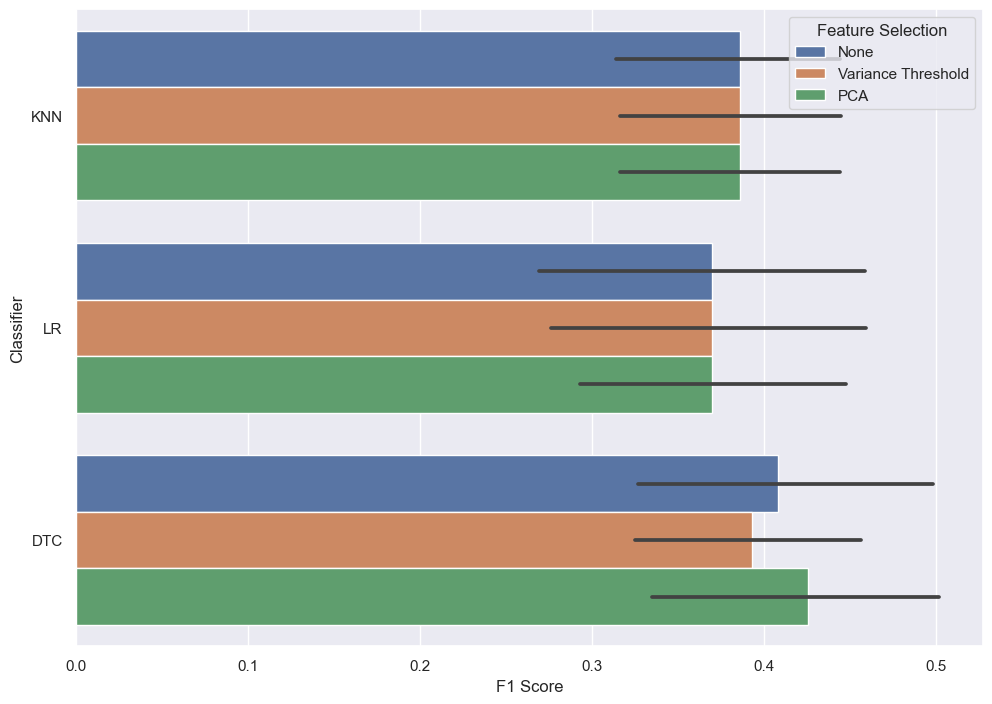

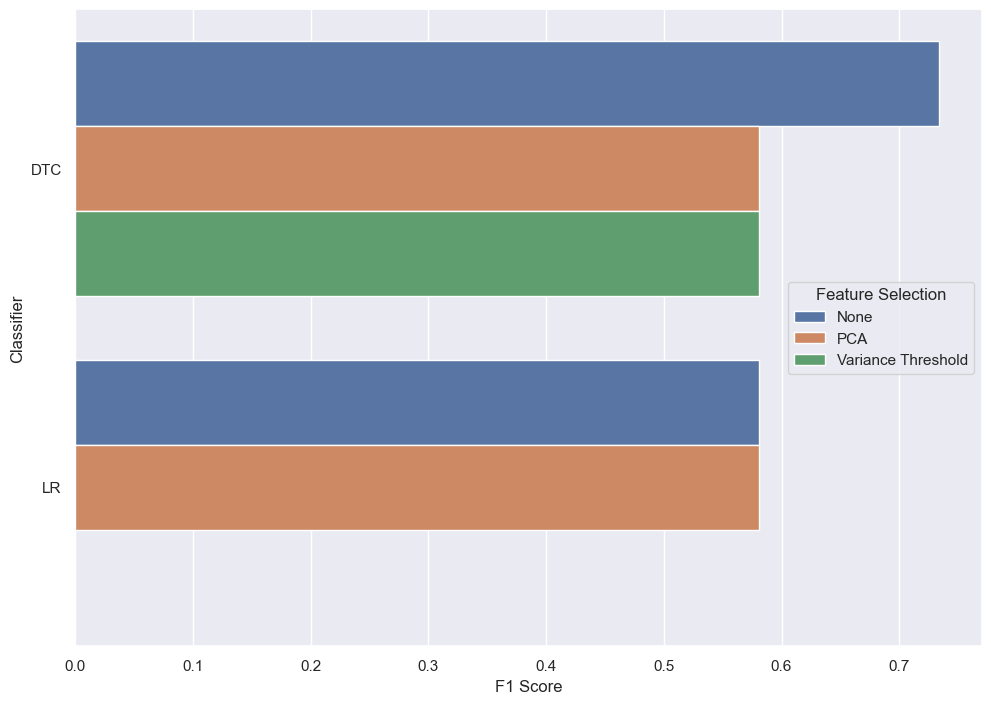

In [24]:
# plot the results
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="F1 Score", y="Classifier", hue="Feature Selection", data=test_results)
plt.show()

# plot the best 3 models
sns.set_theme(style="whitegrid")
sns.set(rc={'figure.figsize':(11.7,8.27)})
ax = sns.barplot(x="F1 Score", y="Classifier", hue="Feature Selection", data=best_models)
plt.show()

**Impact of Dataset Quality**: The quality of images ('Good', 'Mixed', 'Bad') affects the performance of the classifiers. For example, from the table, it seems that classifiers tend to perform worse on 'Bad' images compared to 'Good' or 'Mixed'.

**Effect of Feature Selection**: The type of feature selection method also affects the performance of classifiers. It's a bit harder to draw a definite conclusion on this without more statistical analysis, but it seems like the feature selection method 'PCA' seems to be performing better for 'Mixed' and 'Bad' dataset when using DTC classifier.

**Performance of Classifiers**: The classifiers seem to have varied performance based on the dataset and feature selection method. For example, in the 'Bad' images dataset, DTC seems to have the highest F1 score when 'None' feature selection method is applied.

In [26]:
# Load test results
test_results_df = test_models(path_to_good_test_set, csv_path)

# Merge all_results and test_results_df based on common columns
merged_results = pd.merge(all_results, test_results_df, on=["Dataset", "Feature Selection", "Classifier"], suffixes=("_Train", "_Test"))

# Display the merged results
merged_results

,Dataset,Feature Selection,Classifier,F1 Score_Train,Accuracy,Precision,Recall,ROC AUC,F1 Score_Test
0,Good,None,KNN,0.816431,0.742857,0.797626,0.854230,0.696271,0.412587
1,Good,None,LR,0.816431,0.742857,0.797626,0.854230,0.696271,0.142857
2,Good,None,DTC,0.816431,0.742857,0.797626,0.854230,0.696271,0.333333
3,Good,Variance Threshold,KNN,0.814585,0.739683,0.795126,0.854230,0.693240,0.412587
4,Good,Variance Threshold,LR,0.814585,0.739683,0.795126,0.854230,0.693240,0.142857
5,Good,Variance Threshold,DTC,0.814585,0.739683,0.795126,0.854230,0.693240,0.333333
6,Good,PCA,KNN,0.835081,0.771429,0.822869,0.865994,0.732802,0.412587
7,Good,PCA,LR,0.835081,0.771429,0.822869,0.865994,0.732802,0.142857
8,Good,PCA,DTC,0.835081,0.771429,0.822869,0.865994,0.732802,0.495798
9,Mixed,None,KNN,0.734594,0.656313,0.712543,0.778168,0.612053,0.250000


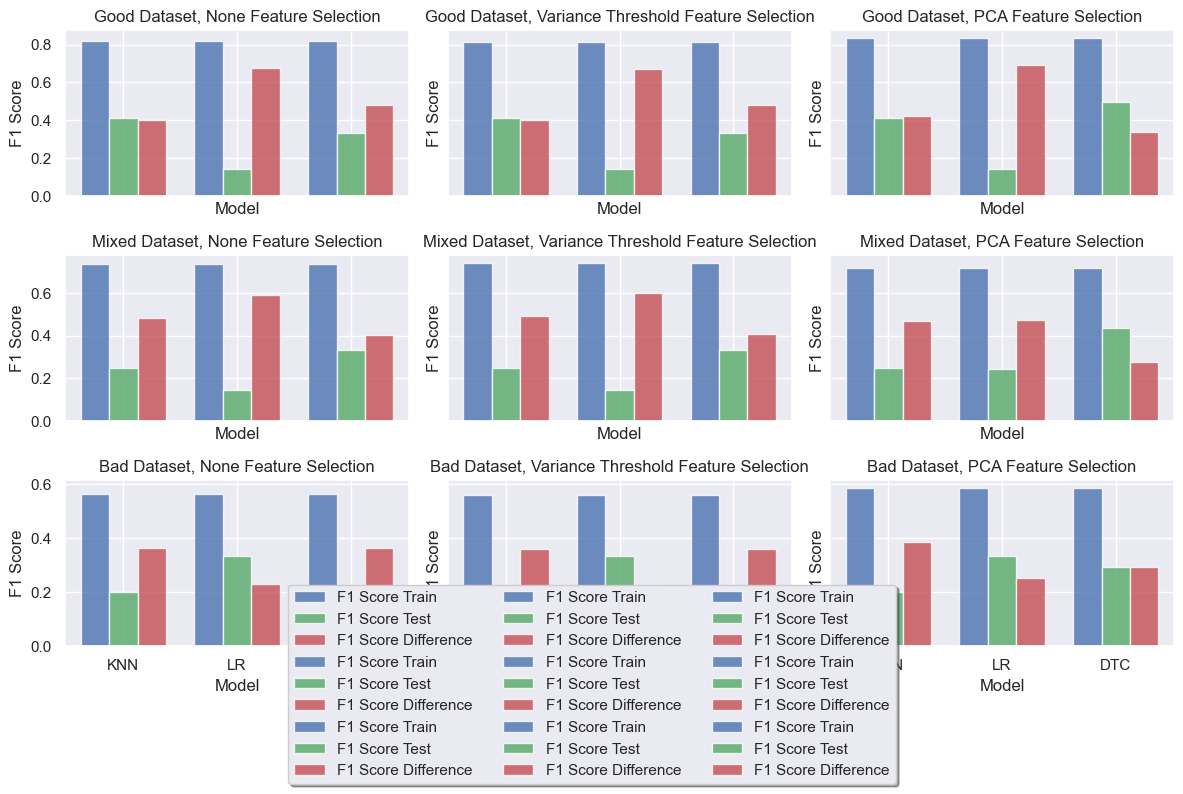

In [32]:
# Get unique datasets and feature selections
unique_datasets = merged_results['Dataset'].unique()
unique_feature_selections = merged_results['Feature Selection'].unique()

# Calculate the number of subplots
num_datasets = len(unique_datasets)
num_feature_selections = len(unique_feature_selections)

# Set the figure size and create subplots
fig, axs = plt.subplots(num_datasets, num_feature_selections, figsize=(12, 8), sharey='row')

# Loop over datasets and feature selections
for i, dataset in enumerate(unique_datasets):
    for j, feature_selection in enumerate(unique_feature_selections):
        # Filter the merged results for the specific dataset and feature selection
        filtered_results = merged_results[(merged_results['Dataset'] == dataset) & (merged_results['Feature Selection'] == feature_selection)]
        
        # Get the data for the subplots
        x = np.arange(len(filtered_results))
        train_scores = filtered_results['F1 Score_Train']
        test_scores = filtered_results['F1 Score_Test']
        difference_scores = filtered_results['F1 Score_Difference']

        # Set the subplot
        if num_datasets > 1 and num_feature_selections > 1:
            ax = axs[i, j]
        elif num_datasets > 1:
            ax = axs[i]
        elif num_feature_selections > 1:
            ax = axs[j]
        else:
            ax = axs

        # Grouped bar plot
        bar_width = 0.25
        opacity = 0.8

        ax.bar(x, train_scores, bar_width, alpha=opacity, color='b', label='F1 Score Train')
        ax.bar(x + bar_width, test_scores, bar_width, alpha=opacity, color='g', label='F1 Score Test')
        ax.bar(x + 2 * bar_width, difference_scores, bar_width, alpha=opacity, color='r', label='F1 Score Difference')

        # Add labels and title
        ax.set_xlabel('Model')
        ax.set_ylabel('F1 Score')
        ax.set_title(f'{dataset} Dataset, {feature_selection} Feature Selection')
        ax.set_xticks(x + bar_width)
        ax.set_xticklabels(filtered_results['Classifier'])

        # Hide x-axis labels for all but the bottom subplots
        if i < num_datasets - 1:
            ax.tick_params(labelbottom=False)

# Position the legend outside the subplots
fig.legend(loc='lower center', bbox_to_anchor=(0.5, -0.1), fancybox=True, shadow=True, ncol=3)

# Adjust the layout and spacing between subplots
plt.tight_layout(rect=[0, 0, 1, 0.9])

# Hide the individual subplots' legends
for ax in axs.flat:
    ax.legend().set_visible(False)

# Show the plot
plt.show()
